In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/SIC_share/price_new.csv')

# Display the first few rows of the data to understand its structure
data.head()


,date,open,high,low,close,volume,symbol
0,2023-01-03,39.30,41.20,39.05,41.20,1732900,BID
1,2023-01-04,41.20,42.20,40.40,40.80,2070300,BID
2,2023-01-05,41.00,41.10,40.25,40.75,1175100,BID
3,2023-01-06,40.75,42.45,40.60,41.65,3400900,BID
4,2023-01-09,42.20,42.20,40.85,41.00,1326400,BID


In [4]:
# Convert 'Date' column to datetime and set it as the index
data['date'] = pd.to_datetime(data['date'])

# Ensure each symbol has its data scaled individually
symbols = data['symbol'].unique()
scalers = {}

# Dictionary to hold the training data for each symbol
symbol_data_dict = {}

# Scaling the data for each symbol
for symbol in symbols:
    symbol_data = data[data['symbol'] == symbol].copy()
    symbol_data.set_index('date', inplace=True)

    # Scale the prices for this symbol
    scaler = MinMaxScaler(feature_range=(0, 1))
    symbol_data['Scaled_Price'] = scaler.fit_transform(symbol_data[['close']])

    # Store the scaler and scaled data
    scalers[symbol] = scaler
    symbol_data_dict[symbol] = symbol_data

# Check the processed data for one symbol
symbol_data_dict[symbols[0]].head()


,open,high,low,close,volume,symbol,Scaled_Price
date,,,,,,,
2023-01-03,39.30,41.20,39.05,41.20,1732900,BID,0.151125
2023-01-04,41.20,42.20,40.40,40.80,2070300,BID,0.125402
2023-01-05,41.00,41.10,40.25,40.75,1175100,BID,0.122186
2023-01-06,40.75,42.45,40.60,41.65,3400900,BID,0.180064
2023-01-09,42.20,42.20,40.85,41.00,1326400,BID,0.138264


In [5]:
# Function to create sequences of 60 time steps to predict the next price
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Dictionary to hold training sequences for each symbol
symbol_sequences = {}

# Creating sequences for each symbol
for symbol in symbols:
    symbol_data = symbol_data_dict[symbol]['Scaled_Price'].values.reshape(-1, 1)
    X, y = create_sequences(symbol_data)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshaping for LSTM input
    symbol_sequences[symbol] = (X, y)

# Check the shape of training data for one symbol
symbol_sequences[symbols[0]][0].shape, symbol_sequences[symbols[0]][1].shape


((346, 60, 1), (346,))

In [6]:
X_train, y_train = symbol_sequences[symbols[0]]
# Build the RNN model with LSTM layers
model = Sequential()

# Add the first LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dense(50, activation='relu'))

# Add a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Add a Dense layer with one output (the predicted price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60, 50)              │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,201 (129.69 KB)

 Trainable params: 33,201 (129.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.1957 - val_loss: 0.0495
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0303 - val_loss: 0.0078
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0196 - val_loss: 0.0055
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0123 - val_loss: 0.0087
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0127 - val_loss: 0.0058
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0099 - val_loss: 0.0071
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0084 - val_loss: 0.0061
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0069 - val_l

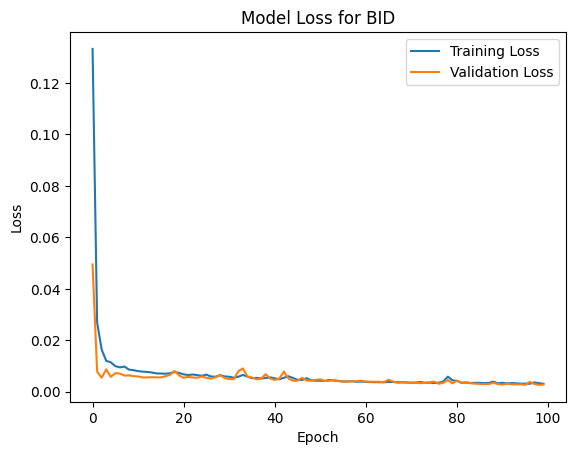

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0.1409 - val_loss: 0.0334
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0238 - val_loss: 0.0269
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0129 - val_loss: 0.0208
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0098 - val_loss: 0.0193
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0078 - val_loss: 0.0215
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0077 - val_loss: 0.0186
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0064 - val_loss: 0.0196
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0065 - val_loss: 0.0185
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0059 - val_loss: 0.0185
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0057 - val_loss: 0.0178
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0059 - val_loss: 0.0195
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0069 - val_l

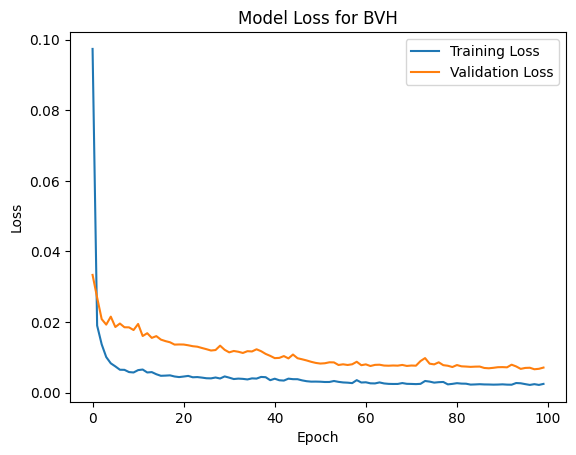

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.1652 - val_loss: 0.0718
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0406 - val_loss: 0.0161
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0204 - val_loss: 0.0065
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0162 - val_loss: 0.0070
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0117 - val_loss: 0.0069
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0095 - val_loss: 0.0065
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0085 - val_l

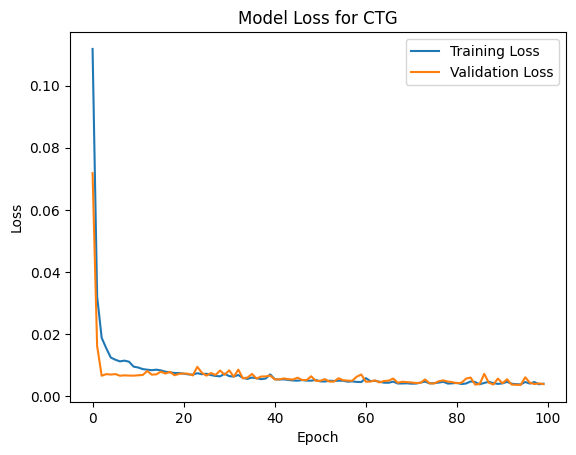

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0666 - val_loss: 0.0135
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0131 - val_loss: 0.0603
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0063 - val_loss: 0.0176
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0034 - val_loss: 0.0076
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0023 - val_loss: 0.0078
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0023 - val_l

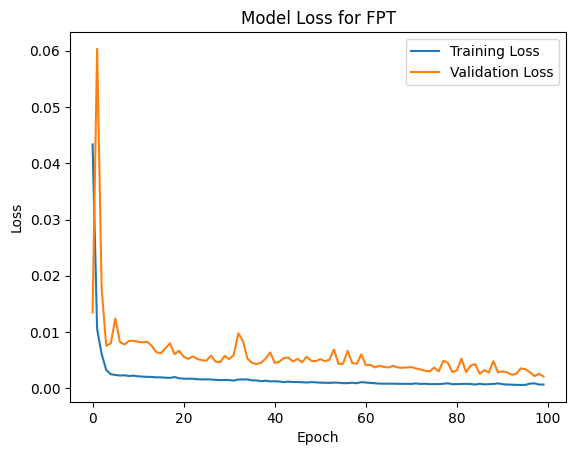

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.1460 - val_loss: 0.0227
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0226 - val_loss: 0.0049
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0162 - val_loss: 0.0085
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0144 - val_loss: 0.0049
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0105 - val_loss: 0.0042
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0093 - val_loss: 0.0044
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0090 - val_loss: 0.0040
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0080 - val_lo

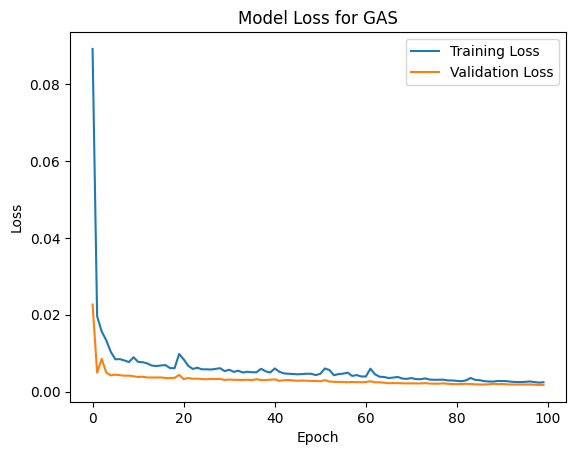

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0384 - val_loss: 0.0104
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0076 - val_loss: 0.0239
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0031 - val_loss: 0.0086
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0025 - val_l

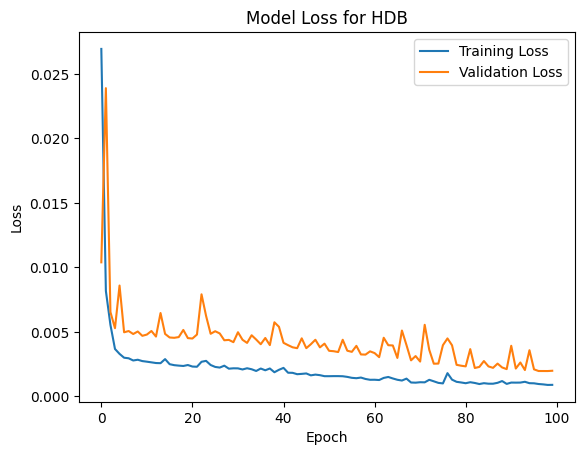

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.2446 - val_loss: 0.0378
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0241 - val_loss: 0.0137
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0137 - val_loss: 0.0075
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0058 - val_loss: 0.0071
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0056 - val_lo

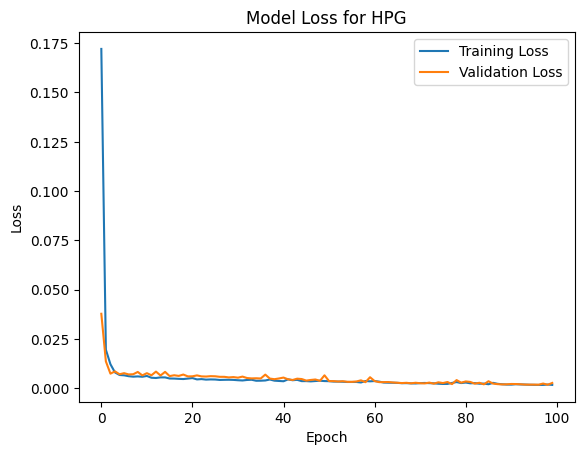

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.2172 - val_loss: 0.0366
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0267 - val_loss: 0.0383
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0178 - val_loss: 0.0088
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0111 - val_loss: 0.0166
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0089 - val_loss: 0.0122
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0106 - val_loss: 0.0058
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0071 - val_loss: 0.0098
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0078 - val_l

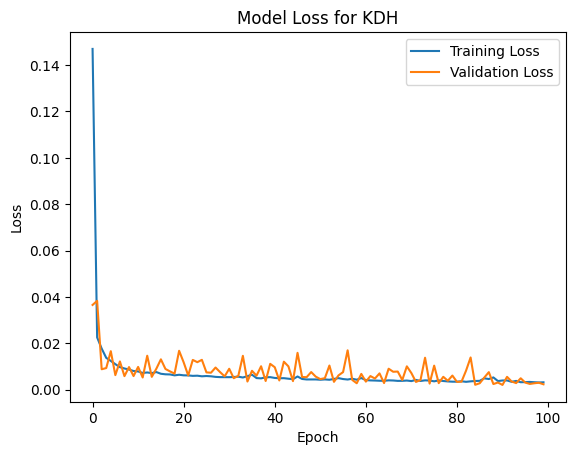

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.1398 - val_loss: 0.0076
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0220 - val_loss: 0.0152
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0154 - val_loss: 0.0123
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0095 - val_loss: 0.0144
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0082 - val_loss: 0.0094
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0076 - val_loss: 0.0133
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0060 - val_l

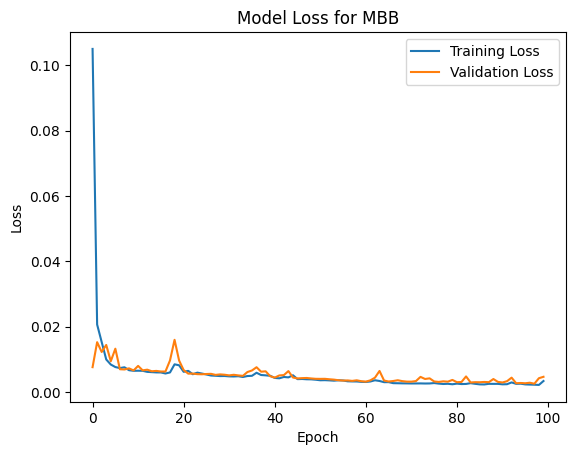

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0688 - val_loss: 0.0203
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0172 - val_loss: 0.0089
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0110 - val_loss: 0.0034
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0041 - val_l

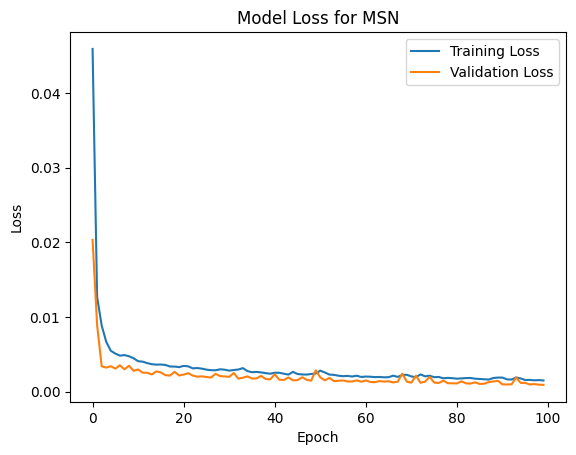

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0400 - val_loss: 0.0047
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0063 - val_loss: 0.0488
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0053 - val_loss: 0.0216
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0044 - val_loss: 0.0077
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0036 - val_loss: 0.0154
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0035 - val_loss: 0.0123
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0031 - val_loss: 0.0104
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0033 - val_l

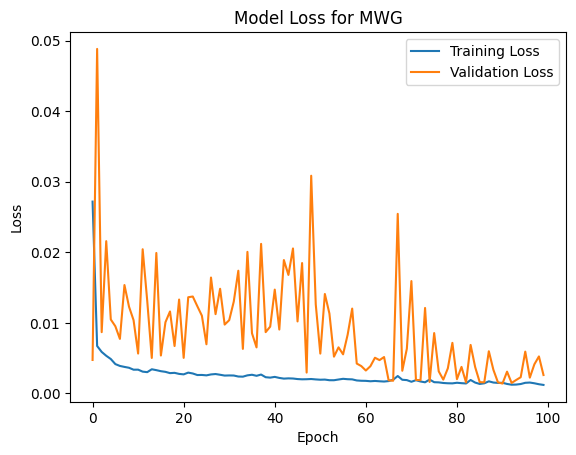

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.2177 - val_loss: 0.0569
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0275 - val_loss: 0.0076
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0155 - val_loss: 0.0198
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0121 - val_loss: 0.0164
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0098 - val_loss: 0.0132
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0102 - val_loss: 0.0145
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0081 - val_loss: 0.0121
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0083 - val_loss: 0.0098
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0089 - val_loss: 0.0111
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0066 - val_l

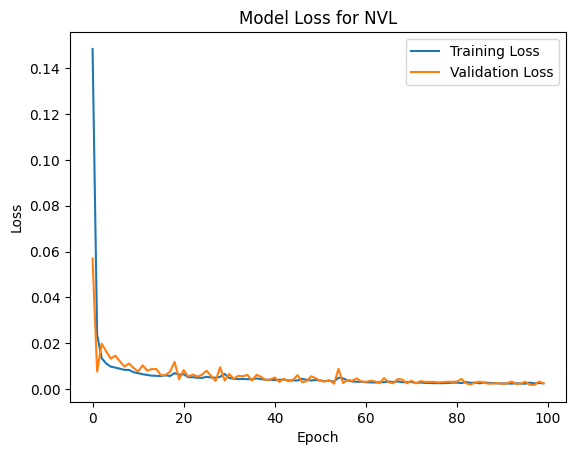

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.1960 - val_loss: 0.1341
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0269 - val_loss: 0.0069
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0153 - val_loss: 0.0204
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0071 - val_loss: 0.0130
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0040 - val_loss: 0.0175
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0041 - val_loss: 0.0083
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0038 - val_loss: 0.0125
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0032 - val_loss: 0.0116
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0031 - val_loss: 0.0109
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0033 - val_l

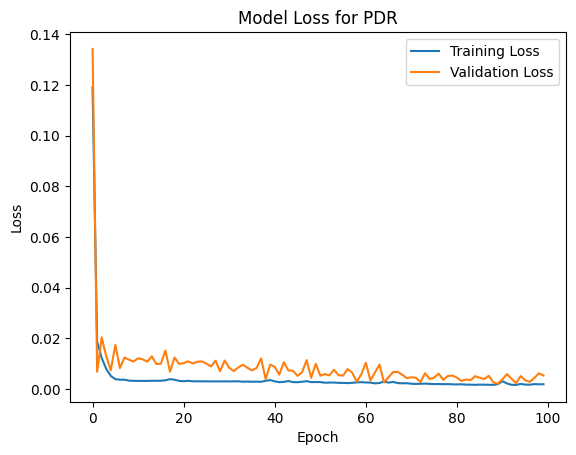

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0834 - val_loss: 0.0296
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0090 - val_loss: 0.0561
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0067 - val_loss: 0.0485
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0051 - val_loss: 0.0260
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0041 - val_loss: 0.0380
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0038 - val_loss: 0.0196
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0042 - val_loss: 0.0214
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0038 - val_loss: 0.0136
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0034 - val_loss: 0.0147
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0034 - val_loss: 0.0147
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0033 - val_l

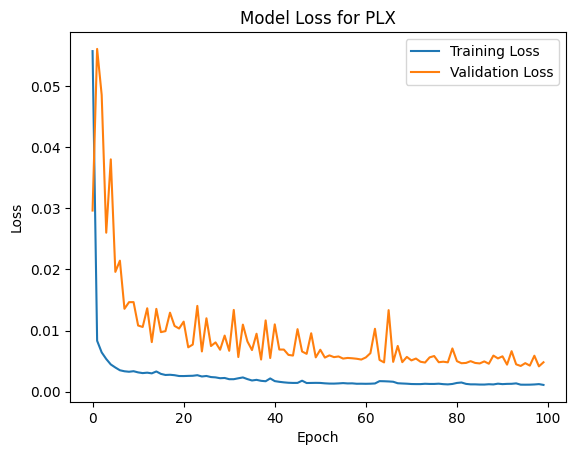

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0952 - val_loss: 0.0319
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0174 - val_loss: 0.0298
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0121 - val_loss: 0.0044
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0048 - val_loss: 0.0114
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0038 - val_loss: 0.0077
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0041 - val_l

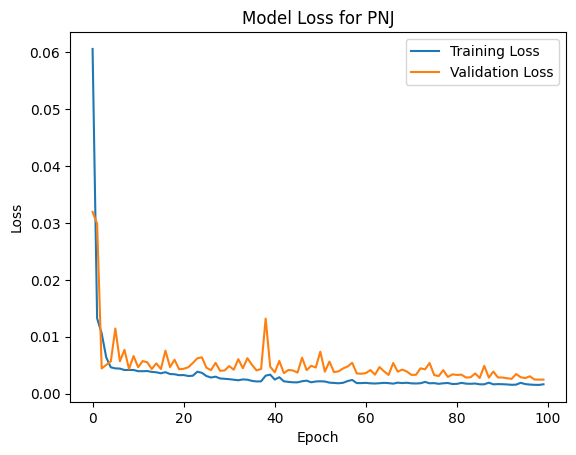

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0627 - val_loss: 0.0331
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0097 - val_loss: 0.0504
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0087 - val_loss: 0.0268
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0054 - val_loss: 0.0333
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0055 - val_loss: 0.0264
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0042 - val_loss: 0.0264
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0038 - val_loss: 0.0251
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0044 - val_loss: 0.0241
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0033 - val_loss: 0.0235
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040 - val_loss: 0.0212
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0036 - val_loss: 0.0197
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0038 - val_l

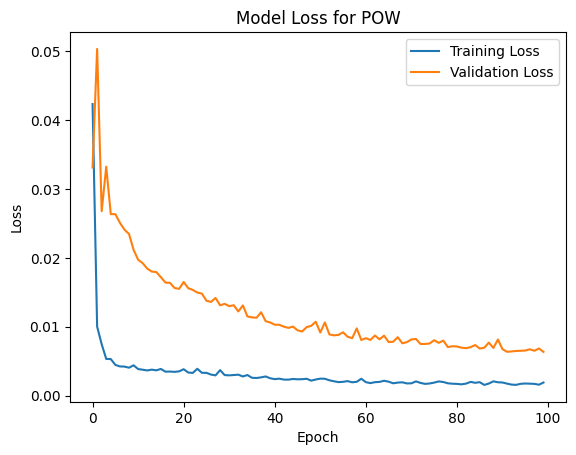

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.1510 - val_loss: 0.0285
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0253 - val_loss: 0.0401
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0141 - val_loss: 0.0218
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0073 - val_loss: 0.0199
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0096 - val_loss: 0.0217
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0076 - val_loss: 0.0198
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0071 - val_loss: 0.0218
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0065 - val_loss: 0.0184
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0058 - val_loss: 0.0217
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0061 - val_loss: 0.0178
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0062 - val_l

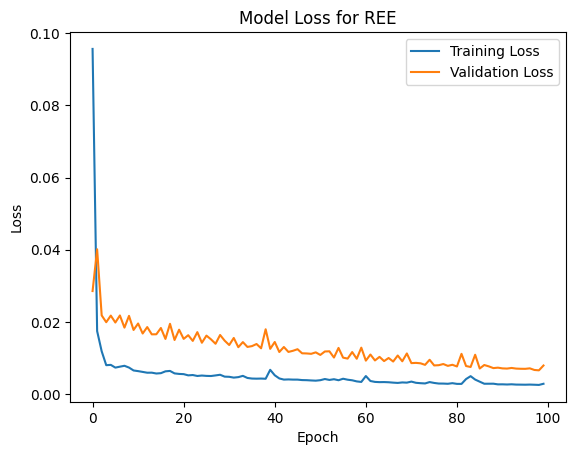

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.1871 - val_loss: 0.0413
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0467 - val_loss: 0.0062
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0257 - val_loss: 0.0105
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0080 - val_l

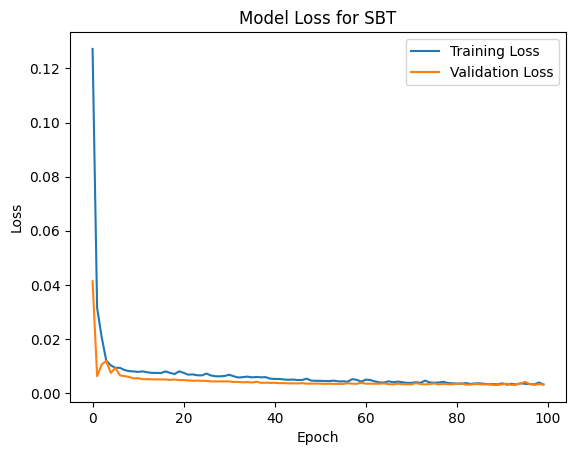

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.2171 - val_loss: 0.1108
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0376 - val_loss: 0.0208
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0181 - val_loss: 0.0045
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0048 - val_l

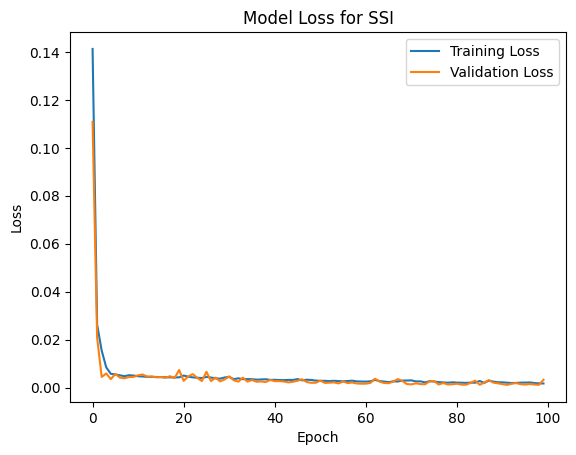

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.2107 - val_loss: 0.1114
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0570 - val_loss: 0.0176
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0250 - val_loss: 0.0098
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0125 - val_loss: 0.0166
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0103 - val

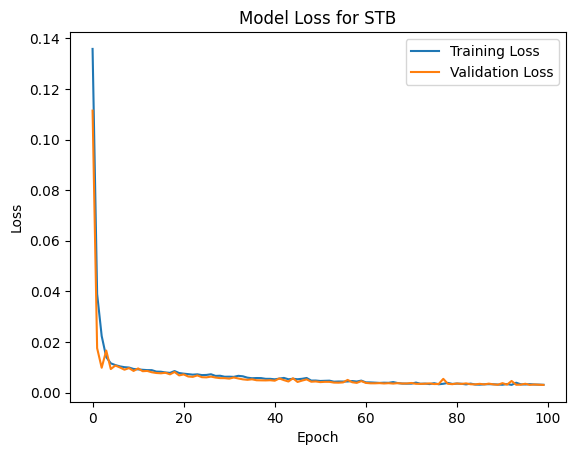

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0905 - val_loss: 0.1067
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0110 - val_loss: 0.0617
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0091 - val_loss: 0.0613
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0055 - val_loss: 0.0510
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040 - val_loss: 0.0505
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0035 - val_loss: 0.0504
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0032 - val_loss: 0.0478
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0025 - val_loss: 0.0505
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0022 - val_loss: 0.0498
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0022 - val_loss: 0.0486
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0023 - val_loss: 0.0520
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0023 - val_l

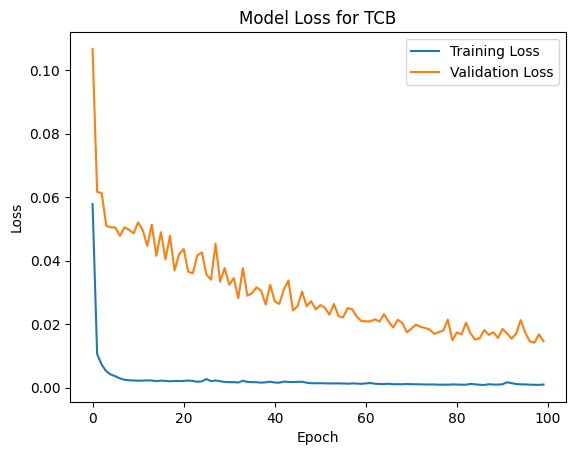

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0835 - val_loss: 0.0128
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0120 - val_loss: 0.0617
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0060 - val_loss: 0.0107
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0049 - val_loss: 0.0175
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0037 - val_loss: 0.0109
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0034 - val_loss: 0.0077
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0026 - val_l

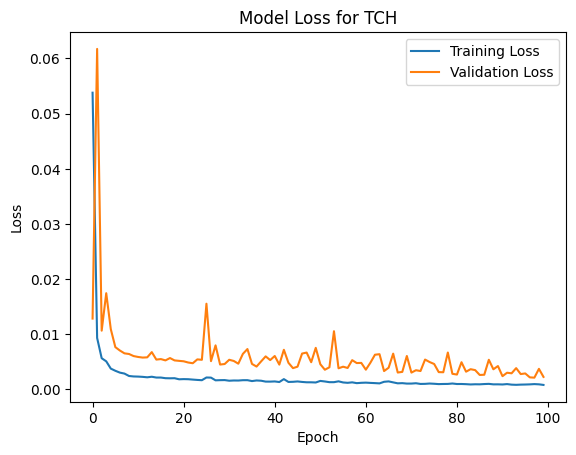

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.1325 - val_loss: 0.0152
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0220 - val_loss: 0.0022
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0206 - val_loss: 0.0033
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0138 - val_loss: 0.0032
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0104 - val_loss: 0.0021
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0131 - val_loss: 0.0023
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0135 - val_loss: 0.0020
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0121 - val_loss: 0.0038
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0096 - val_loss: 0.0019
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0093 - val_loss: 0.0023
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0090 - val_l

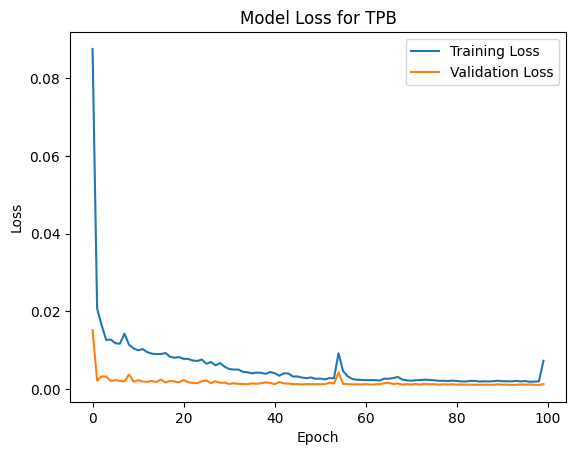

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.1218 - val_loss: 0.0460
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0291 - val_loss: 0.0037
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0224 - val_loss: 0.0043
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0148 - val_loss: 0.0071
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0119 - val_loss: 0.0026
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0111 - val_loss: 0.0066
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0117 - val_loss: 0.0043
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0106 - val_loss: 0.0028
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0095 - val_loss: 0.0028
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0114 - val_l

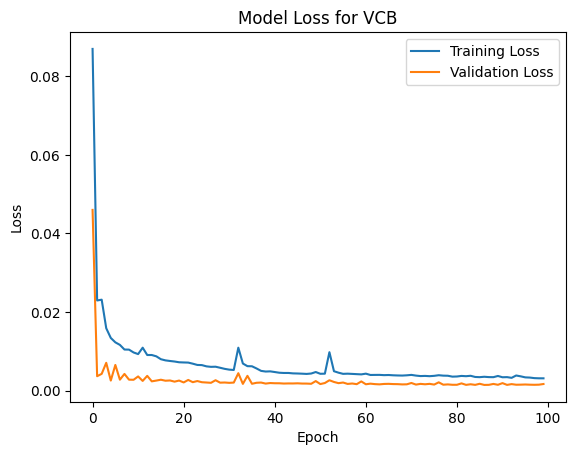

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.1705 - val_loss: 0.0355
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0383 - val_loss: 0.0028
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0185 - val_loss: 0.0064
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0050 - val_l

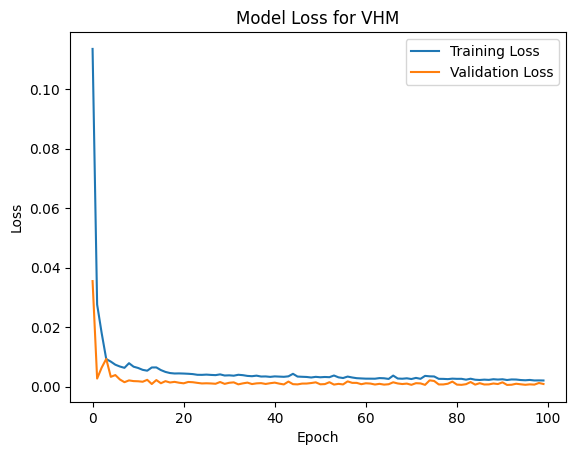

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0838 - val_loss: 0.0281
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0314 - val_loss: 0.0047
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0178 - val_loss: 0.0041
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0150 - val_loss: 0.0098
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0105 - val_loss: 0.0051
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0093 - val_loss: 0.0030
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0044 - val_l

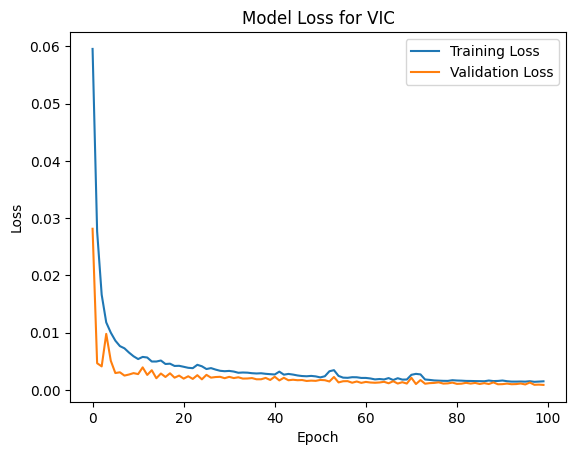

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0523 - val_loss: 0.0445
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0170 - val_loss: 0.0475
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0124 - val_loss: 0.0281
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0084 - val_loss: 0.0287
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0081 - val_loss: 0.0292
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0073 - val_loss: 0.0258
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0077 - val_loss: 0.0276
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0078 - val_loss: 0.0251
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0074 - val_loss: 0.0246
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0073 - val_loss: 0.0236
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0066 - val_loss: 0.0227
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0064 - val_l

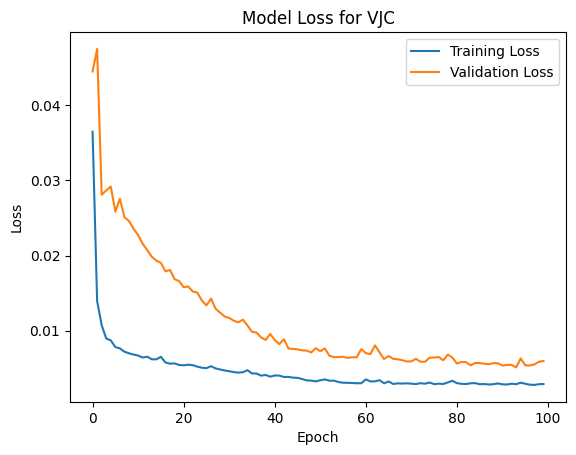

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.1518 - val_loss: 0.0263
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0298 - val_loss: 0.0166
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0206 - val_loss: 0.0160
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0108 - val_loss: 0.0129
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0092 - val_loss: 0.0099
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0091 - val_l

In [ ]:
# Function to build and compile the RNN model
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store the trained models
models = {}

# Train models for each symbol
for symbol in symbols:
    X_train, y_train = symbol_sequences[symbol]

    # Build the model
    model = build_rnn_model((X_train.shape[1], X_train.shape[2]))

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25, verbose=1)

    # Store the model
    models[symbol] = model

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {symbol}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
# Evaluate each model using RMSE
for symbol in symbols:
    X_train, y_train = symbol_sequences[symbol]
    model = models[symbol]

    # Predict on the training data
    predictions = model.predict(X_train)

    # Inverse transform the predictions and actual prices
    predictions = scalers[symbol].inverse_transform(predictions)
    actual_prices = scalers[symbol].inverse_transform(y_train.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
    mae = mean_absolute_error(actual_prices, predictions)
    print(f'RMSE for {symbol}: {rmse}')
    print(f'MAE for {symbol}: {mae}')


In [ ]:
# Predict 21 days of stock prices for each symbol
future_predictions = {}

for symbol in symbols:
    model = models[symbol]

    # Get the last 60 days of data for prediction
    last_60_days = symbol_data_dict[symbol]['Scaled_Price'].values[-60:]
    last_60_days = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))  # Reshaping to (1, 60, 1)

    # Predict the next 21 days
    symbol_predictions = []

    for _ in range(21):
        predicted_price = model.predict(last_60_days)
        symbol_predictions.append(predicted_price[0, 0])

        # Update last_60_days with the new prediction
        # Ensure predicted_price has the correct shape for concatenation
        predicted_price = np.reshape(predicted_price, (1, 1, 1))  # Reshape to (1, 1, 1)
        last_60_days = np.append(last_60_days[:, 1:, :], predicted_price, axis=1)

    # Inverse transform the predictions to original scale
    symbol_predictions = scalers[symbol].inverse_transform(np.array(symbol_predictions).reshape(-1, 1))

    # Store the predictions
    future_predictions[symbol] = symbol_predictions

# Display predictions for one symbol
future_predictions[symbols[0]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

array([[46.840836],
       [46.99913 ],
       [47.089375],
       [47.131607],
       [47.140118],
       [47.12519 ],
       [47.09405 ],
       [47.051636],
       [47.00129 ],
       [46.945248],
       [46.885014],
       [46.821625],
       [46.755814],
       [46.688114],
       [46.61896 ],
       [46.548717],
       [46.477695],
       [46.406166],
       [46.334404],
       [46.262627],
       [46.19107 ]], dtype=float32)

In [ ]:
predicted_data = []

for symbol in symbols:
    predictions = future_predictions[symbol]

    # Generate dates from 2024-08-21 to 2024-09-10
    prediction_dates = pd.date_range(start='2024-08-21', end='2024-09-10')

    for i, date in enumerate(prediction_dates):
        predicted_data.append([symbol, date.strftime('%Y-%m-%d'), predictions[i, 0]])

# Convert the predicted data into a DataFrame
predicted_df = pd.DataFrame(predicted_data, columns=['symbol', 'Date', 'Price'])

# Save the predictions to sub_2.csv
predicted_df.to_csv('/content/drive/MyDrive/SIC_share/sub_2.csv', index=False)

# Confirm the save path
'/content/drive/MyDrive/SIC_share/sub_2.csv'

'/content/drive/MyDrive/SIC_share/sub_2.csv'